<a href="https://colab.research.google.com/github/koll-ai/control-meme-api/blob/main/control_meme_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.2
added 22 packages from 22 contributors in 1.644s


In [1]:
#@title # Install dependencies

! pip install "git+https://github.com/takuma104/diffusers.git@controlnet" # Diffusers in development version
! pip install transformers accelerate safetensors xformers opencv-python
! pip install --pre -U triton
!pip install flask-cors
! npm install -g localtunnel


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/takuma104/diffusers.git (to revision controlnet) to /tmp/pip-req-build-ed5f4__j
  Running command git clone --filter=blob:none --quiet https://github.com/takuma104/diffusers.git /tmp/pip-req-build-ed5f4__j
  Running command git checkout -b controlnet --track origin/controlnet
  Switched to a new branch 'controlnet'
  Branch 'controlnet' set up to track remote branch 'controlnet' from 'origin'.
  Resolved https://github.com/takuma104/diffusers.git to commit bd5d7b7463de71eb4b7cff8958ff4a0e06c4a289
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/tools/node/bin/lt -> /tools/node/lib

Error caught was: module 'triton.language' has no attribute 'constexpr'


In [1]:
#@title # Load ControlNet pipeline

import requests
from diffusers import StableDiffusionControlNetPipeline, EulerAncestralDiscreteScheduler
from diffusers.utils import load_image
import torch
import cv2
import numpy as np
from PIL import Image

from flask import Flask
from flask import request
import base64
from io import BytesIO

import subprocess
import time


model = "takuma104/control_sd15_canny" #@param {type:"string"}

#Common
euler_scheduler = EulerAncestralDiscreteScheduler.from_config("takuma104/control_sd15_canny", subfolder="scheduler")

#Canny Edge model
pipe_canny = StableDiffusionControlNetPipeline.from_pretrained("takuma104/control_sd15_canny", torch_dtype=torch.float16).to("cuda")
pipe_canny.scheduler = euler_scheduler
pipe_canny.enable_xformers_memory_efficient_attention()


Error caught was: module 'triton.language' has no attribute 'constexpr'
/usr/local/lib/python3.8/dist-packages/diffusers/configuration_utils.py:195: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [2]:
#@title # Setup localtunnel
with open('output.txt', 'w') as f:
    proc = subprocess.Popen(['lt', '--port', '5000'], stdout=f)

time.sleep(3)

  0%|          | 0/10 [00:00<?, ?it/s]

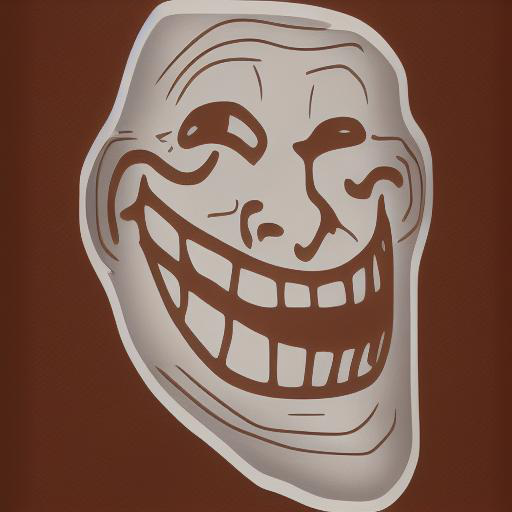

In [4]:
import cv2 as cv

def generate_controlnet(params):
    """
    Generate a meme variation
    POST params: prompt:str, negative_prompt:str, controlnet_hint_url:str, num_inference_steps:int, seed:int
    """
    
    if 'seed' in params:
      generator = torch.Generator(device="cuda").manual_seed(params["seed"])
    else:
      generator = torch.Generator(device="cuda")
    
    # get controlnet hint image
    init_image = Image.open(requests.get(params["controlnet_hint_url"], stream=True).raw)
    init_image = init_image.resize((512,512))
    controlnet_hint = Image.fromarray(cv.Canny(np.array(init_image), 100,200))
    controlnet_hint.save('cur_hint.jpeg')
    


    image = pipe_canny(prompt=params.get("prompt"), 
                      negative_prompt=params.get("negative_prompt"),
                      controlnet_hint=controlnet_hint,
                      num_inference_steps=params["num_inference_steps"], 
                      generator=generator).images[0]
    


    with open('./last.jpeg', 'w') as f:
      image.save(f, format="JPEG")
    return image
# b64 = generate_controlnet({"prompt": "test", "negative_prompt": "test", "controlnet_hint_url": "https://storage.googleapis.com/control-meme-public/TrollFace.jpg", "num_inference_steps": 10, "seed": 42})
# im = Image.open(BytesIO(base64.b64decode(b64)))
# im


In [5]:
#@title # Run the service
from flask_cors import CORS

app = Flask(__name__)
CORS(app)

last_image = None
last_uuid = None
last_prompt = None
last_nb_steps = None

API_URL = ""

@app.route('/', methods=['POST'])
def index():
    global last_image
    global last_uuid
    global last_prompt
    global last_nb_steps

    params = request.get_json()
    last_uuid = params['uuid']
    last_image = generate_controlnet(params)
    last_prompt = params['prompt']
    last_nb_steps = params["num_inference_steps"]

    buffered = BytesIO()
    last_image.save(buffered, format="JPEG")

    return base64.b64encode(buffered.getvalue())


@app.route('/save_last/')
def save_last():
    global last_uuid
    global last_image
    global last_prompt
    global last_nb_steps
    requests.post(f'{API_URL}/api/meme/{last_uuid}/variation/',
                  files=dict(
                      file=open('./last.jpeg'),
                      prompt=last_prompt,
                      nb_steps=last_nb_steps
                      ) )
    
    return "ok"


@app.route('/hello/')
def hello():
    
    return "hello"

if __name__ == '__main__':
  with open('output.txt', 'r') as f:
      contents = f.read()
      API_URL = contents.split(' ')[-1]
      protocol = API_URL.split(':')[0]
      url = API_URL.split('/')[-1]

      print(API_URL)

      print('\n'*2)
      print(f'Everything is ready! Click on the this link to be redirected to koll.ai. Don\'t close this tab!')
      print(f'https://meme.koll.ai?protocol={protocol}&url={url}')

  app.run()

https://tasty-breads-end-34-69-5-237.loca.lt




Everything is ready! Click on the this link to be redirected to koll.ai. Don't close this tab!
https://meme.koll.ai?protocol=https&url=tasty-breads-end-34-69-5-237.loca.lt

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
INFO:werkzeug:127.0.0.1 - - [24/Feb/2023 02:46:39] "OPTIONS / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Feb/2023 02:47:28] "OPTIONS / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Feb/2023 02:48:15] "OPTIONS / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Feb/2023 02:53:16] "OPTIONS / HTTP/1.1" 200 -


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:werkzeug:127.0.0.1 - - [24/Feb/2023 02:53:27] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Feb/2023 02:55:56] "OPTIONS / HTTP/1.1" 200 -


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:werkzeug:127.0.0.1 - - [24/Feb/2023 02:56:06] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Feb/2023 02:59:11] "OPTIONS / HTTP/1.1" 200 -


  0%|          | 0/50 [00:00<?, ?it/s]

INFO:werkzeug:127.0.0.1 - - [24/Feb/2023 02:59:22] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Feb/2023 02:59:34] "OPTIONS / HTTP/1.1" 200 -


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:werkzeug:127.0.0.1 - - [24/Feb/2023 02:59:56] "POST / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [24/Feb/2023 03:00:23] "OPTIONS / HTTP/1.1" 200 -


  0%|          | 0/100 [00:00<?, ?it/s]

INFO:werkzeug:127.0.0.1 - - [24/Feb/2023 03:00:44] "POST / HTTP/1.1" 200 -
